In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from gridtools.hypnotoad_tools import *
from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from code_comparison.code_comparison import *
import matplotlib as mpl

%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# IO

In [2]:

toload = {
    "base" : "stc1b-base_rerun",
    "mxorder1" : "stc2a-mxorder1",
    "minmod" : "stc3a-fixes_evolvep_minmod",
    "new_curve" : "stc5a-upgrade_ar_curve",
    # "logistic" : "stc7b-ar2pc-newcurves",
    "logarithmic_optimised" : "stc9b-ar2pc",
    
}

cs = dict()   # casestore

for name in toload:
    print(f"Loading {toload[name]}")
    cs[name] = Load.case_1D(os.path.join(onedrive_path, rf"Project\collab\tech\cases\step1d_shocktests\{toload[name]}"))


Loading stc1b-base_rerun


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading stc2a-mxorder1


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading stc3a-fixes_evolvep_minmod


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading stc5a-upgrade_ar_curve


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading stc9b-ar2pc


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


In [4]:
write_file(cs, "a2b.pkl")

a2b.pkl written


In [9]:
cs = read_file("a2b.pkl")

a2.pkl loaded


# Plots

In [10]:
toload

{'base': 'stc1b-base_rerun',
 'mxorder1': 'stc2a-mxorder1',
 'minmod': 'stc3a-fixes_evolvep_minmod',
 'new_curve': 'stc5a-upgrade_ar_curve',
 'logarithmic_optimised': 'stc9b-ar2pc'}

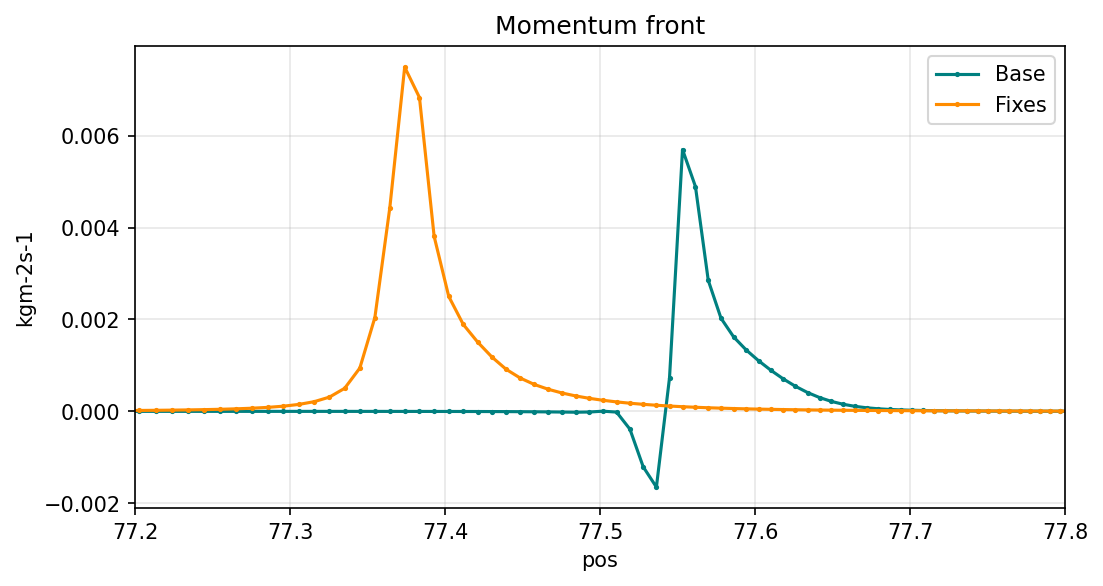

In [9]:
fig, ax = plt.subplots(1,  figsize=(8,4), dpi = 150)

lw = 1.5
labels = ["Base", "Fixes"]
colors = ["teal", "darkorange"]

for i, name in enumerate(["mxorder1", "minmod"]):
    ds = cs[name].ds.isel(pos=slice(2,-2), t =-1)
    ds["NVd+"].plot(ax = ax, c = colors[i], marker = "o", ms = 1.5, label = labels[i])

ax.set_xlim(77.2,77.8)
# ax.set_yscale("symlog", linthreshy = 1e-3)
ax.set_ylabel("kgm-2s-1")
ax.set_title("Momentum front")
ax.legend()
ax.grid(alpha = 0.3)

In [12]:
cs[name].ds.data_vars

Data variables:
    Bxy                 (pos) float64 dask.array<chunksize=(52,), meta=np.ndarray>
    Dd_Dpar             (t, pos) float64 dask.array<chunksize=(301, 52), meta=np.ndarray>
    Ed+_iz              (t, pos) float64 dask.array<chunksize=(301, 52), meta=np.ndarray>
    Ed+_rec             (t, pos) float64 dask.array<chunksize=(301, 52), meta=np.ndarray>
    Ed_Dpar             (t, pos) float64 dask.array<chunksize=(301, 52), meta=np.ndarray>
    Edd+_cx             (t, pos) float64 dask.array<chunksize=(301, 52), meta=np.ndarray>
    Fd+_iz              (t, pos) float64 dask.array<chunksize=(301, 52), meta=np.ndarray>
    Fd+_rec             (t, pos) float64 dask.array<chunksize=(301, 52), meta=np.ndarray>
    Fd_Dpar             (t, pos) float64 dask.array<chunksize=(301, 52), meta=np.ndarray>
    Fdd+_cx             (t, pos) float64 dask.array<chunksize=(301, 52), meta=np.ndarray>
    G1                  (pos) float64 dask.array<chunksize=(52,), meta=np.ndarray>
    G2  

Text(0, 0.5, 'Number of RHS calls per simulation time')

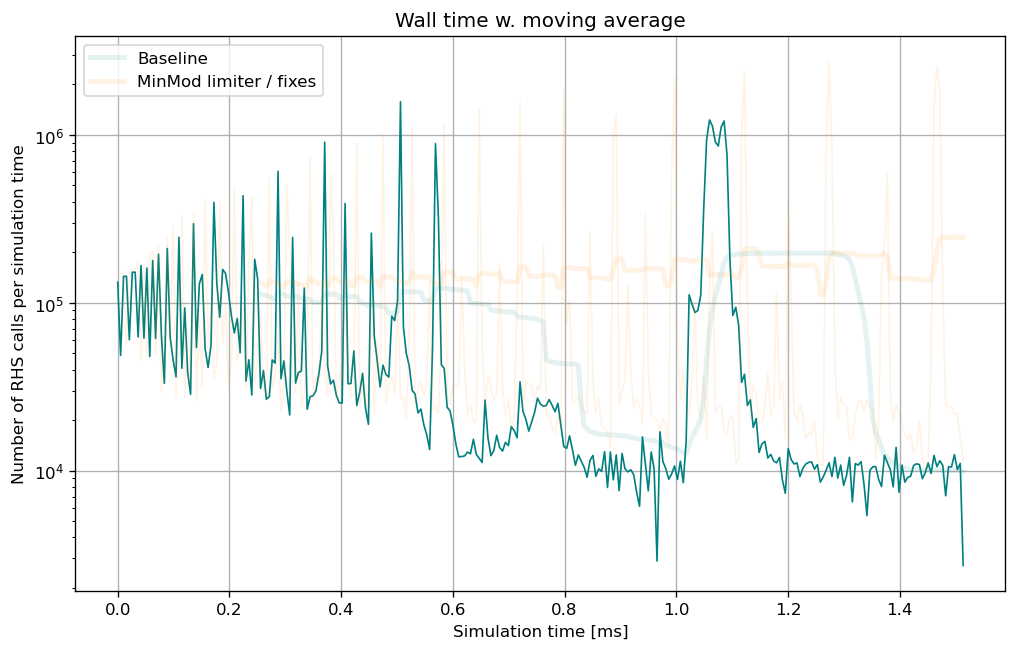

In [24]:
fig, ax = plt.subplots(figsize = (10,6), dpi = 120)
labels = ["Baseline", "MinMod limiter / fixes", "MinMod and fixed cooling curve", "Optimised grid"]
markers = ["s", "d", "o", "v", "x"]
colors = cs[name].ds.metadata["colors"]

for i, name in enumerate(["mxorder1", "minmod"]):
    
    data = cs[name].ds["ncalls"].isel(t=slice(10,None))
    t = (data["t"] - data["t"].values[0]) * 100
    if i == 0:
        alpha = 1
    else:
        alpha = 0.1
    ax.plot(t, data.values,  lw =1, marker = markers[i], ms = 0, color =colors[i], alpha = alpha)
    ax.plot(t, data.rolling(t = 50).mean(), color = colors[i], label = labels[i],lw = 3, alpha = 0.1)
    # print(f"{name}: {cs[name].ds['wtime'].sum()/3600:.2f} hours")
    
ax.set_yscale("log")
ax.legend()
ax.grid()
ax.set_title("Wall time w. moving average")
ax.set_xlabel("Simulation time [ms]")
ax.set_ylabel("Number of RHS calls per simulation time")

Text(0, 0.5, 'Seconds per second simulation time')

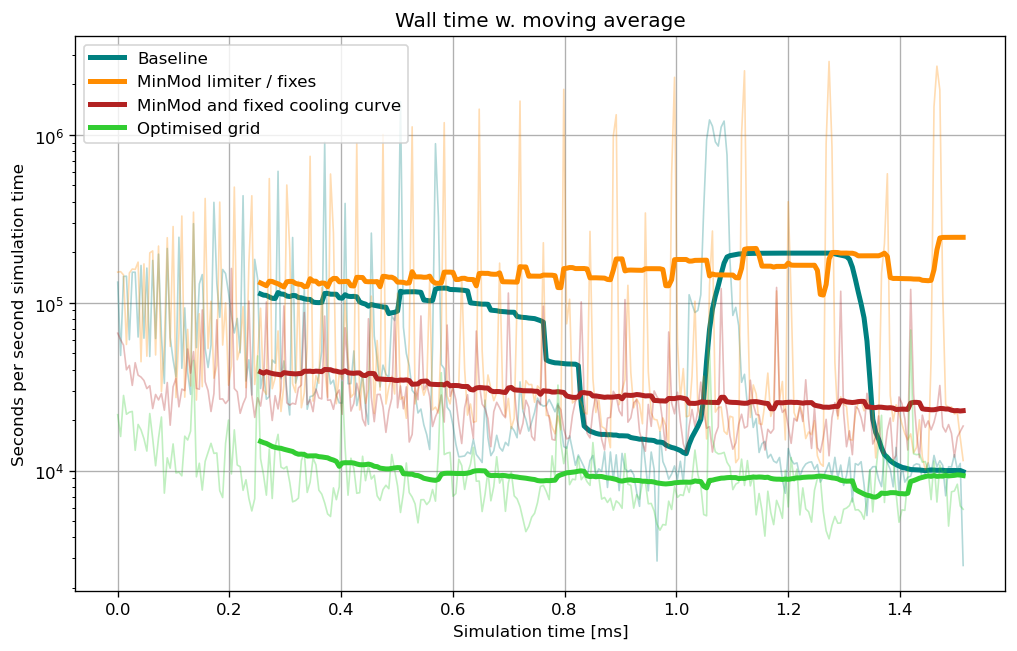

In [27]:
fig, ax = plt.subplots(figsize = (10,6), dpi = 120)
labels = ["Baseline", "MinMod limiter / fixes", "MinMod and fixed cooling curve", "Optimised grid"]
markers = ["s", "d", "o", "v", "x"]
colors = cs[name].ds.metadata["colors"]

for i, name in enumerate(["mxorder1", "minmod", "new_curve", "logarithmic_optimised"]):
    
    data = cs[name].ds["ncalls"].isel(t=slice(10,None))
    t = (data["t"] - data["t"].values[0]) * 100
    ax.plot(t, data.values,  alpha = 0.3, lw =1, marker = markers[i], ms = 0, color =colors[i])
    ax.plot(t, data.rolling(t = 50).mean(), color = colors[i], label = labels[i],lw = 3)
    # print(f"{name}: {cs[name].ds['wtime'].sum()/3600:.2f} hours")
    
ax.set_yscale("log")
ax.legend()
ax.grid()
ax.set_title("Wall time w. moving average")
ax.set_xlabel("Simulation time [ms]")
ax.set_ylabel("Seconds per second simulation time")

## Analysis of the secondary slowdown

### Residuals
- Clear spike in Pe only.

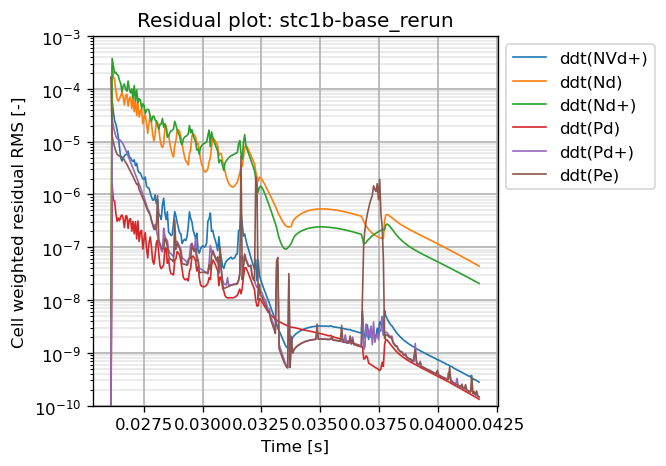

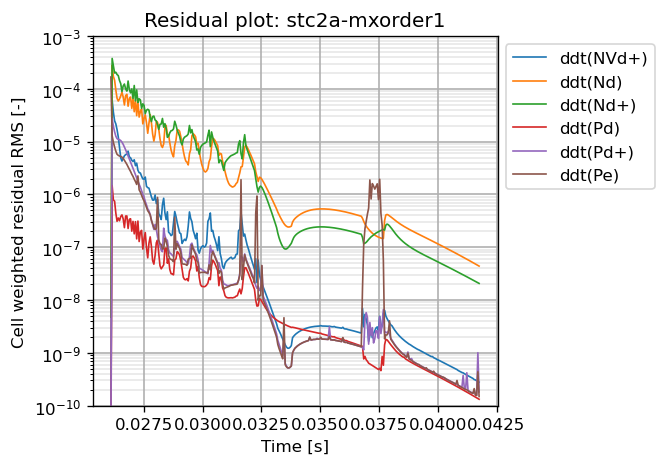

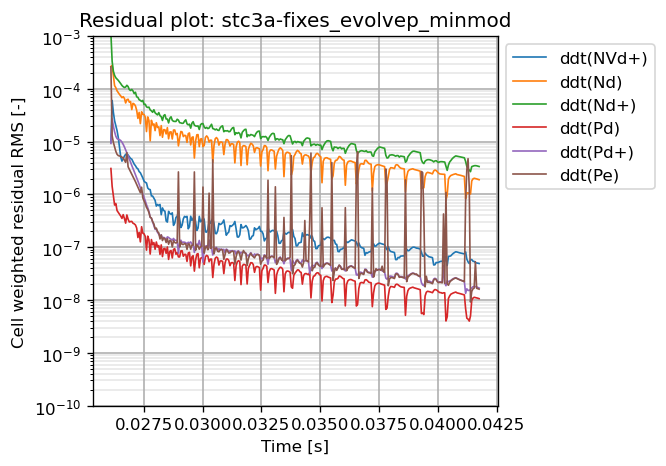

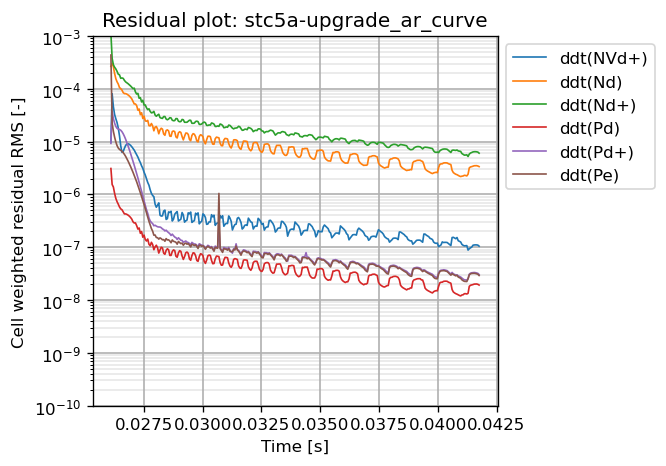

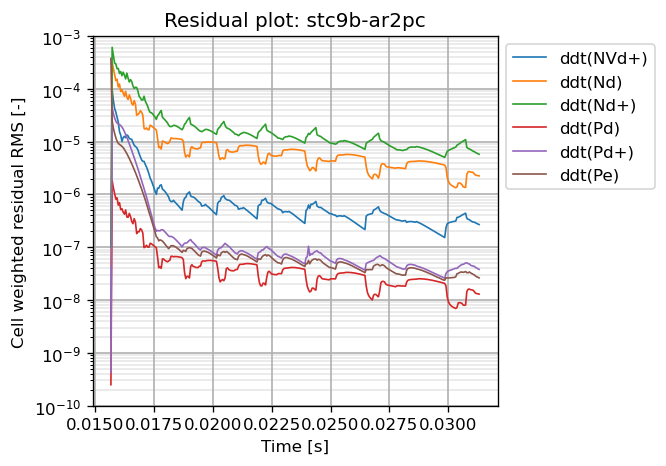

In [18]:
for name in toload:
    plot_ddt(cs[name], ylims = (1e-10, 1e-3))

# How has the MinMod slope limiter impacted the case?

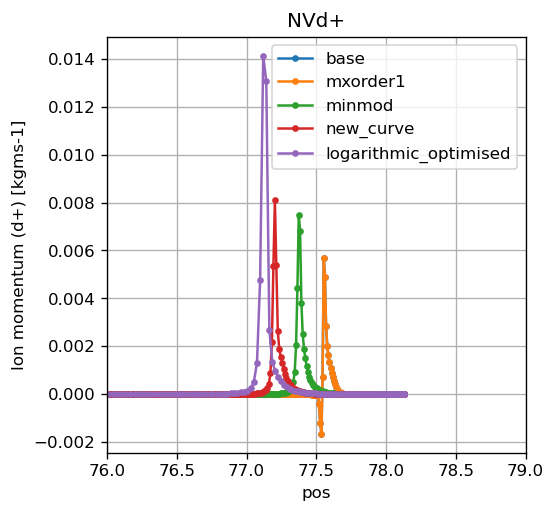

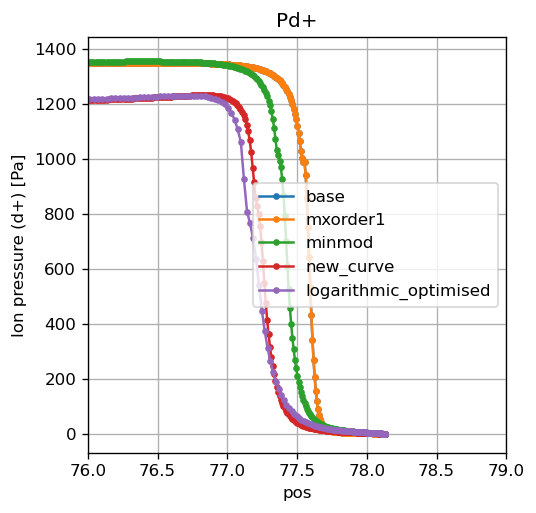

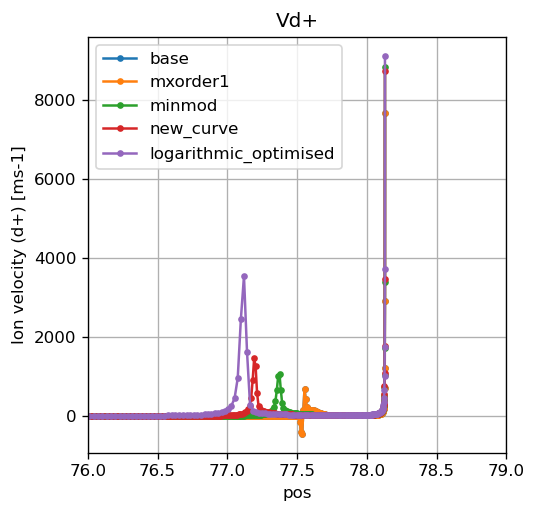

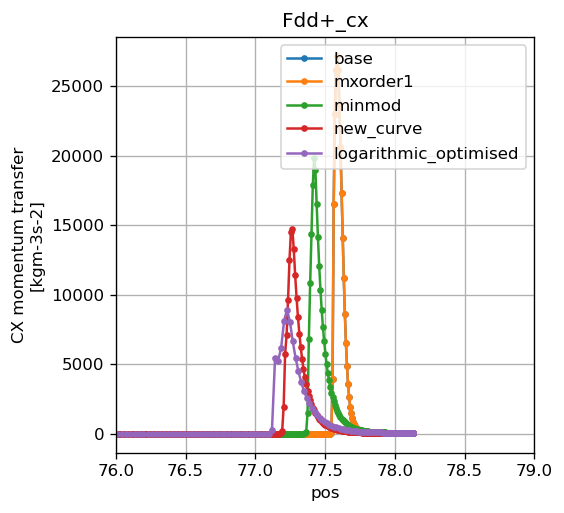

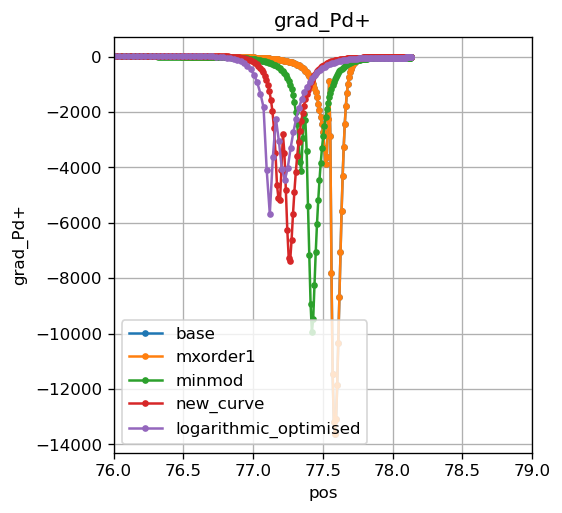

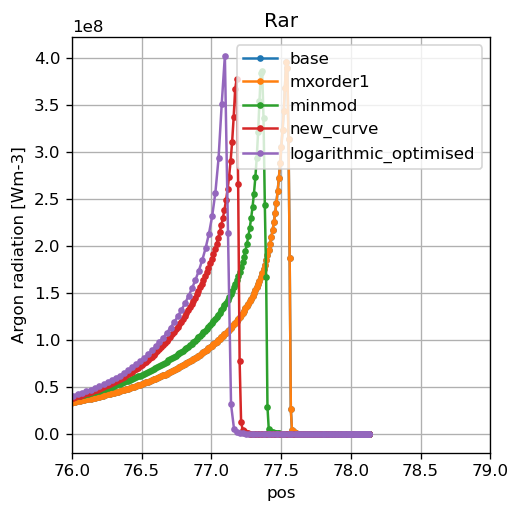

In [20]:
for param in ["NVd+", "Pd+", "Vd+", "Fdd+_cx", "grad_Pd+", "Rar"]:
    fig, ax = plt.subplots(figsize=(4.5,4.5), dpi = 120)

    for name in toload:
        ds = cs[name].ds.isel(pos=slice(1,-1)).isel(t=-1)
        if param == "grad_Pd+":
            ds["grad_Pd+"] = ds["Pd+"].differentiate("pos")
        ds[param].plot(ax = ax, marker = "o", ms = 3, label = name)

    ax.set_xlim(76, 79)
    ax.legend()
    ax.grid()
    ax.set_title(param)

## Pressure source decomposition
- Note that Edd+_cx is so spiky because Td+ is almost exactly Tn and they overlap inconsistently due to grid

### Net

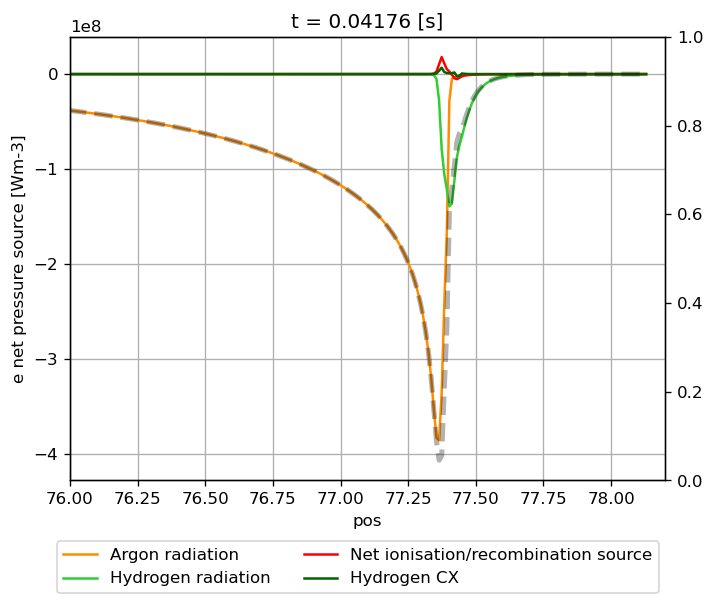

In [ ]:
ds = cs["minmod"].ds.isel(t=-1, pos = slice(2,-2))

fig, ax = plt.subplots(dpi = 120)
ax2 = ax.twinx()

(ds["Rar"]*-1).plot(ax = ax, c = "darkorange", label = "Argon radiation")
ds["Rd+_ex"].plot(ax = ax, c = "limegreen", label = "Hydrogen radiation")
(ds["Ed+_rec"] + ds["Ed+_iz"]).plot(ax = ax, c = "red", label = "Net ionisation/recombination source")
ds["Edd+_cx"].plot(ax = ax, c = "darkgreen", label = "Hydrogen CX")
((ds["SPe"] + ds["SPd+"])*3/2).plot(ax = ax, c = "k", lw = 3, ls = "--", alpha = 0.3, label = "Net plasma energy source")

ax.set_xlim(76, 78.2)
fig.legend(loc = "lower center", bbox_to_anchor = (0.5, -0.1), ncols = 2)
ax.grid()


### Ion energy balance

Text(0.5, 1.0, 'Ion energy balance')

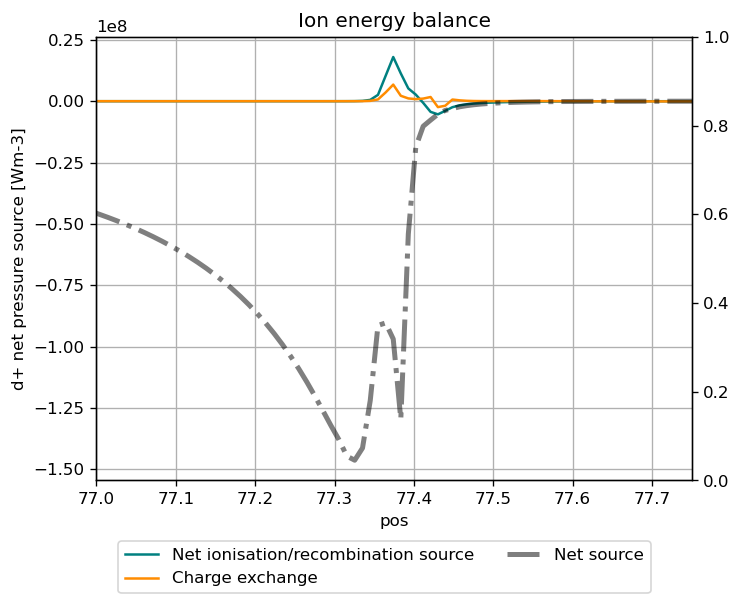

In [17]:
ds = cs["minmod"].ds.isel(t=-1, pos = slice(2,-2))

fig, ax = plt.subplots(dpi = 120)
ax2 = ax.twinx()

(ds["Ed+_rec"] + ds["Ed+_iz"]).plot(ax = ax, c = "teal", label = "Net ionisation/recombination source")
ds["Edd+_cx"].plot(ax = ax, c = "darkorange", label = "Charge exchange")
((ds["SPd+"])*3/2).plot(ax = ax, c = "k", lw = 3, ls = "dashdot", alpha = 0.5, label = "Net source")

ax.set_xlim(77.0, 77.75)
fig.legend(loc = "lower center", bbox_to_anchor = (0.5, -0.1), ncols = 2)
ax.grid()
ax.set_title("Ion energy balance")


### Electron energy balance

Text(0.5, 1.0, 'Electron energy balance')

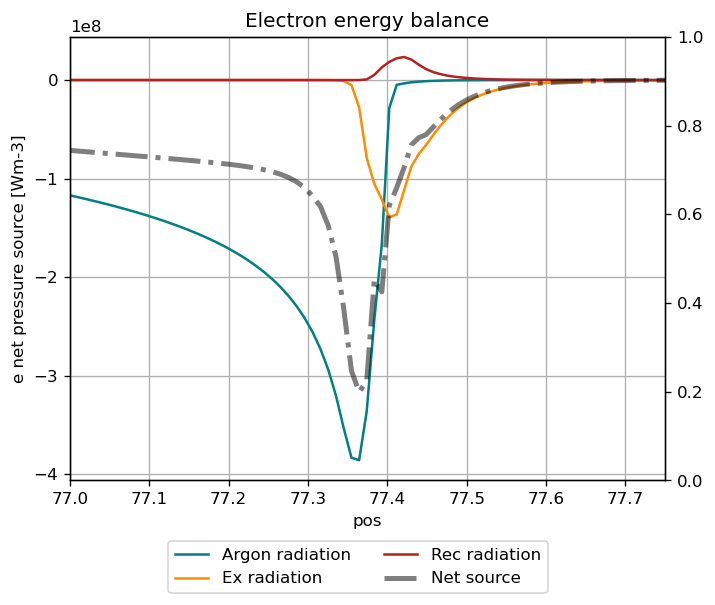

In [16]:
ds = cs["minmod"].ds.isel(t=-1, pos = slice(2,-2))

fig, ax = plt.subplots(dpi = 120)
ax2 = ax.twinx()

(ds["Rar"]*-1).plot(ax = ax, c = "teal", label = "Argon radiation")
ds["Rd+_ex"].plot(ax = ax, c = "darkorange", label = "Ex radiation")
ds["Rd+_rec"].plot(ax = ax, c = "firebrick", label = "Rec radiation")
((ds["SPe"])*3/2).plot(ax = ax, c = "k", lw = 3, ls = "dashdot", alpha = 0.5, label = "Net source")

ax.set_xlim(77.0, 77.75)
fig.legend(loc = "lower center", bbox_to_anchor = (0.5, -0.1), ncols = 2)
ax.grid()
ax.set_title("Electron energy balance")


## How has the new cooling curve impacted the case?

In [28]:
toload

{'base': 'stc1b-base_rerun',
 'mxorder1': 'stc2a-mxorder1',
 'minmod': 'stc3a-fixes_evolvep_minmod',
 'new_curve': 'stc5a-upgrade_ar_curve'}

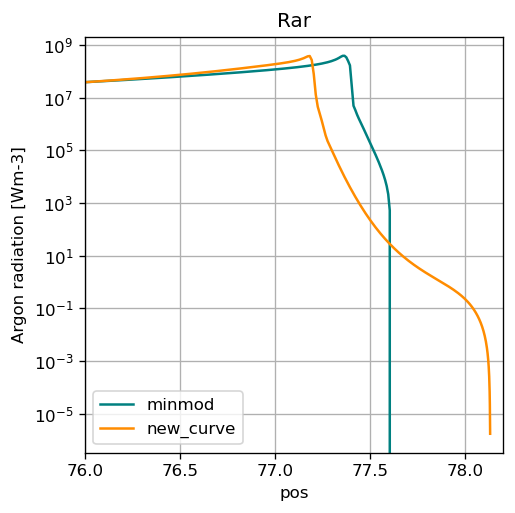

In [55]:
for param in ["Rar"]:
    fig, ax = plt.subplots(figsize=(4.5,4.5), dpi = 120)

    for i, name in enumerate(["minmod", "new_curve"]):
        ds = cs[name].ds.isel(pos=slice(1,-1)).isel(t=-1)
        ds[param].plot(ax = ax, marker = "o", ms = 0, label = name, color = colors[i])

    ax.set_xlim(76, 78.2)
    ax.legend()
    ax.grid()
    ax.set_yscale("log")
    ax.set_title(param)

Text(0, 0.5, 'dR/dt')

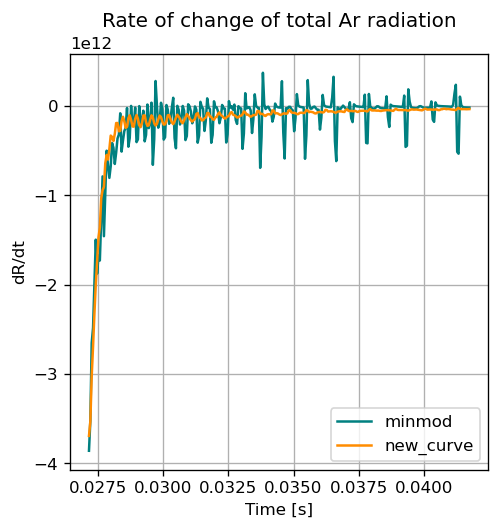

In [48]:

fig, ax = plt.subplots(figsize=(4.5,4.5), dpi = 120)

for i, name in enumerate(["minmod", "new_curve"]):
    ds = cs[name].ds.isel(pos=slice(1,-1), t = slice(20,None))
    data = ds["Rar"].sum("pos").differentiate("t")
    data.plot(ax = ax, marker = "o", ms = 0, label = name, color = colors[i])

# ax.set_xlim(65, 78.2)
ax.legend()
ax.grid()
# ax.set_yscale("log")
ax.set_title("Rate of change of total Ar radiation")
ax.set_ylabel("dR/dt")

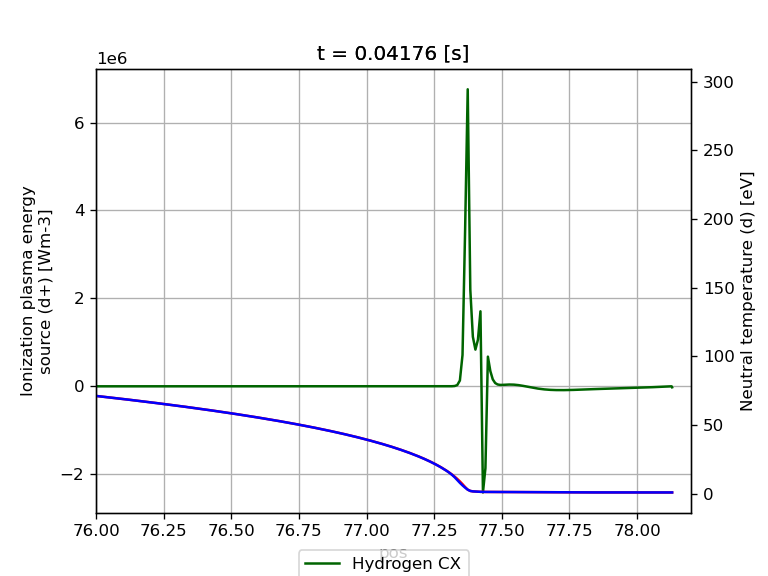

In [7]:
ds = cs["minmod"].ds.isel(t=-1, pos = slice(2,-2))

fig, ax = plt.subplots(dpi = 120)
ax2 = ax.twinx()

# (ds["Rar"]*-1).plot(ax = ax, c = "darkorange", label = "Argon radiation")
# ds["Rd+_ex"].plot(ax = ax, c = "limegreen", label = "Hydrogen radiation")
# (ds["Ed+_rec"] + ds["Ed+_iz"]).plot(ax = ax, c = "red", label = "Net ionisation/recombination source")
ds["Edd+_cx"].plot(ax = ax, c = "darkgreen", label = "Hydrogen CX")

ds["Td+"].plot(ax = ax2, c = "red", label = "Ion temp")
ds["Td"].plot(ax = ax2, c = "blue", label = "Neutral temp")

ax.set_xlim(76, 78.2)
fig.legend(loc = "lower center", bbox_to_anchor = (0.5, -0.1))
ax.grid()


## Walk animation

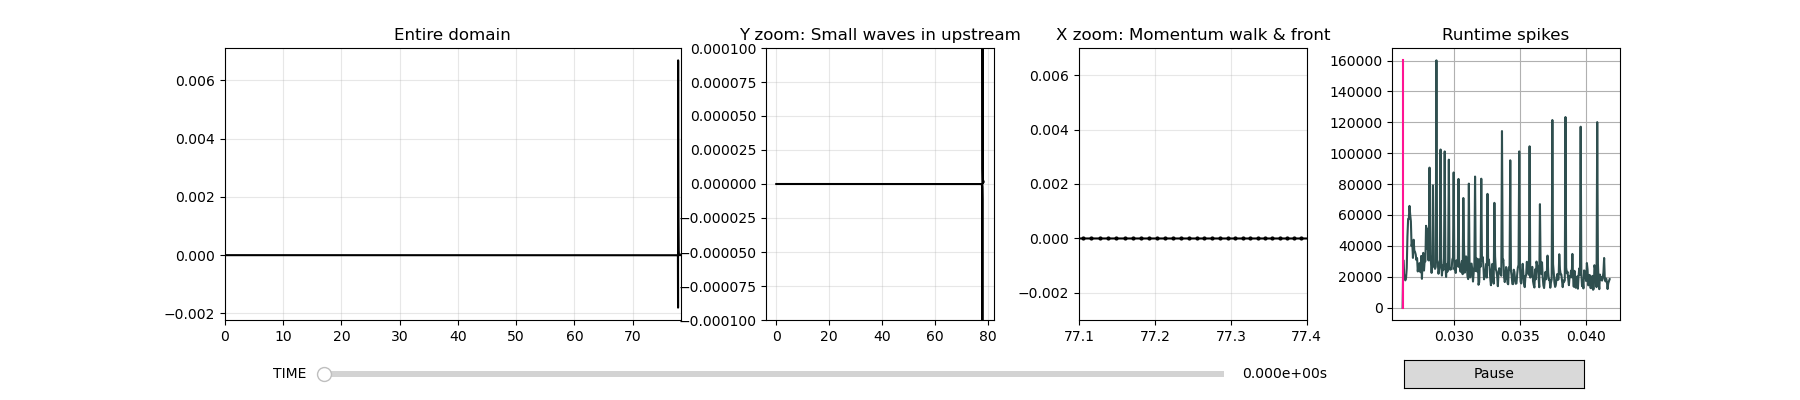

In [13]:
from matplotlib.widgets import RangeSlider, TextBox, Slider
import animatplot as amp

plt.close("all")

dpi = 100

wspace = 0.3
ds = cs["new_curve"].ds.isel(pos=slice(1,-1))
# params = ["NVd+", "Sd+_iz", "Sd+_rec"]
params = ["NVd+", "NVd+", "NVd+"]
# params = ["Sd+_"]
auxparam = ds["ncalls"]
# auxparam = ((ds["Nd+"]+ds["Nd"]) * ds["dv"]).sum("pos")
t = ds.coords["t"].values
num_plots = len(params)

fig = plt.figure(dpi=dpi)
fig.set_figheight(4)
fig.set_figwidth(num_plots*6)
fig.subplots_adjust(bottom = 0.2)

# Plot grid
gs0a = mpl.gridspec.GridSpec(
                                ncols=num_plots+1, nrows=1,
                                wspace = wspace,
                                width_ratios = [0.4, 0.2, 0.2, 0.2]
                                )

axes = [None] * num_plots
data = [None] * num_plots
blocks = [None] * num_plots

timeline = amp.Timeline(t, units = "s", fps = 10)


pos = ds["pos"].values

for i, param in enumerate(params):
    data[i] = ds[param].values

# Make scanning line
vline = np.repeat(np.array([[min(auxparam.values), max(auxparam.values)]]), len(t), axis = 0)



axes[0] = fig.add_subplot(gs0a[0])
blocks[0] = amp.blocks.Line(ds["pos"], ds[param].values, ax = axes[0], color = "black", marker = "o", markersize = 0)
axes[0].set_xlim(0,78.2)
axes[0].set_title("Entire domain")
# axes[0].set_yscale("symlog")

zoomds = ds.sel(pos=slice(None,None)).copy()
axes[1] = fig.add_subplot(gs0a[1])
blocks[1] = amp.blocks.Line(zoomds["pos"], zoomds[param].values, ax = axes[1], color = "black", marker = "o", markersize = 0)
axes[1].set_ylim(-0.0001, 0.0001)
axes[1].set_title("Y zoom: Small waves in upstream")
# axes[1].set_yscale("symlog")


zoomds = ds.sel(pos=slice(76,None)).copy()
axes[2] = fig.add_subplot(gs0a[2])
blocks[2] = amp.blocks.Line(zoomds["pos"], zoomds[param].values, ax = axes[2], color = "black", marker = "o", markersize = 2)
axes[2].set_xlim(77.1, 77.4)
axes[2].set_title("X zoom: Momentum walk & front")
axes[2].set_ylim(-0.003, 0.007)

for i in [0,1,2]:
    axes[i].grid(alpha = 0.3)

# Aux plot and vline
axes.append(fig.add_subplot(gs0a[len(params)]))
axes[-1].plot(t, auxparam, c = "darkslategrey")
axes[-1].grid()
axes[-1].set_title("Runtime spikes")

# Line is two points, these are the X coordinates for those two points for all times
x = np.tile(t,  (2,1)).transpose()
blocks.append(amp.blocks.Line(x, vline, ax = axes[-1], t_axis=0, color = "deeppink"))

# blocks[-1] = 
    
anim = amp.Animation(blocks, timeline)
anim.controls({"text":"TIME", "color":"darkorange", "valfmt":"%1.3e"})
aux_plot_idx = num_plots
    
# anim.save_gif("vis4walk.gif")


